## Margin Recommender by Clustering

In this notebook we will try to predict recommended margin range for when a customer wants to by a new product by using unsupervised learning. 
More specifically we will first cluster products and then customers. After the clustering is performed we can calcuate the upper and lower bound for recommended margin with the following formula: 



We start off by importing the necessary libraries, and reading in the data.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.decomposition import PCA

filepath = 'ECOMMRecords2020.csv'
data = pd.read_csv(filepath)
data_original = data.copy()


### Helper Functions
This section contains a variety of important functions used throughout the project. 

In [3]:
def get_coefficient_variation(data, feature): 
    '''
    The function calculates the coefficient of variation (CV) of the "Margin" for each category in the specified feature.

    Returns a sorted DataFrame with the mean, standard deviation, and CV for each category.
    '''

    grouped_data = data.groupby(feature)
    mean, std = grouped_data["Margin"].mean(), grouped_data["Margin"].std()
    df = pd.concat([mean, std], axis = 1).reset_index()
    df.columns = [feature, "Mean", "Std"]
    df["CoefficientOfVariation"] = (df["Std"]/df["Mean"])**2

    return df.sort_values(by = "CoefficientOfVariation")


In [4]:


def split_data(feature, data):
    '''
    Splits a DataFrame into multiple DataFrames based on the unique values of a specified categorical feature.

    Parameters:
    - feature: The column name to split the DataFrame by.
    - data: The DataFrame to split.

    Returns:
    - A dictionary where keys are unique feature values and values are the corresponding DataFrames.
    '''

    categories = list(data[feature].unique())
    dataframes = {}

    for c in categories: 
        df = data[data[feature] == c]
        dataframes[c] = df
        
    return dataframes


In [5]:
from datetime import datetime

'''
This cell contains all functions that are used to create new features used by the KMeans
algorithms to group products in clusters. 
More functions are needed to create more features to achieve better clustering results. 
'''

def add_average_margin_feature(dataframe):
    means = dataframe.groupby("ProductName")["Margin"].mean().reset_index()
    means.columns = ["ProductName", "MeanMargin"]
    new_df = pd.merge(means, dataframe, on = "ProductName")
    return new_df 
    

def add_average_cost_per_unit_feature(dataframe):
    dataframe.loc[:, "CostPerUnit"] = dataframe["Cost"]/dataframe["Quantity"]
    means = dataframe.groupby("ProductName")["CostPerUnit"].mean().reset_index()
    means.columns = ["ProductName", "MeanCostPerUnit"]
    new_df = pd.merge(means, dataframe, on = "ProductName")
    return new_df 

def add_average_sales_in_past_per_product(n_months, dataframe):
    dataframe["OrderDate"] = pd.to_datetime(dataframe["OrderDate"])
    last_date = dataframe["OrderDate"].max()
    n_months_ago = last_date - pd.DateOffset(months = n_months)
    filtered_data = dataframe[dataframe["OrderDate"] >= n_months_ago]
    meanSales = filtered_data.groupby("ProductName")["Sales"].mean().reset_index()
    meanSales.columns = ["ProductName", "AverageSalesPastMonths"]
    new_df = pd.merge(meanSales, dataframe, on = "ProductName")
    return new_df

def number_of_orders_per_product(dataframe): 
    product_order_counts = dataframe.groupby("ProductID")["OrderID"].count().reset_index()
    product_order_counts = product_order_counts.rename(columns = {"OrderID" : "NumberOfOrders"})
    dataframe = dataframe.merge(product_order_counts, on = "ProductID", how = "left")
    return dataframe
    
def add_total_sales_for_product(dataframe): 
    product_sales = data.groupby("ProductID")["Sales"].sum().reset_index()
    product_sales.columns = ["ProductID", "TotalSales"]
    new_df = pd.merge(dataframe, product_sales, on = "ProductID", how = "left")
    return new_df

def add_total_cost_for_product(dataframe): 
    product_cost = data.groupby("ProductID")["Cost"].sum().reset_index()
    product_cost.columns = ["ProductID", "TotalCost"]
    new_df = pd.merge(dataframe, product_cost, on = "ProductID", how = "left")
    return new_df




# We can do for multiple past months instead of total. Implement this. 

In [6]:
def feature_engineering(dataframes : dict): 
    '''
    The function applies multiple feature engineerings steps to each dataframe in the input dictionary. 

    It then returns a dictionary with the engineered dataframes. 
    '''

    engineered_data = {}

    for category in dataframes.keys(): 
        df = dataframes[category].copy()
        df = add_average_margin_feature(df)
        df = add_average_cost_per_unit_feature(df)
        df = add_average_sales_in_past_per_product(12, df)
        df = number_of_orders_per_product(df)
        df = add_total_sales_for_product(df)
        df = add_total_cost_for_product(df)
        engineered_data[category] = df
    
    return engineered_data


In [7]:


def standardize_features(dataframes : dict, features : list): 
    '''
    The functions standardizes specified features in each dataframe. 

    Returns a new dictionary containing the dataframes containing the scaled specified features.
    '''
    dataframes_scaled = {}

    for category in dataframes.keys():

        data = dataframes[category][features]
        ss = StandardScaler()
        data_scaled = ss.fit_transform(data)
        data_scaled = pd.DataFrame(data_scaled, columns = ss.get_feature_names_out())
        dataframes_scaled[category] = data_scaled
    
    return dataframes_scaled



In [8]:
def find_optimal_k(dataframes : dict): 
    '''
    Identifies the optimal number of clusters for KMeans using the elbow method and plotting the silhouette score. 

    Returns a plot of the interia score and silhouette score versus number of clusters for each of the dataframes 
    in the input dictionary. 
    '''
    ks = [x for x in range(2, 11)]
    inertia_scores = []
    silhouette_scores = []
    
    for category in dataframes.keys(): 
        data = dataframes[category]
        inertia = []
        silhouette = []
        for k in ks: 
            model = KMeans(n_clusters = k, random_state = 42, init = 'k-means++')
            predicted = model.fit_predict(data)
            inertia.append(model.inertia_)
            silhouette.append(silhouette_score(data, predicted))

        inertia_scores.append(inertia)
        silhouette_scores.append(silhouette)
    
    fig, ax = plt.subplots(nrows = len(dataframes.keys()), ncols = 2, figsize = (15, 14), squeeze=False)
    for i in range(len(dataframes.keys())): 
        ax[i, 0].plot(ks, inertia_scores[i])
        ax[i, 1].plot(ks, silhouette_scores[i])
        ax[i, 0].set_xlabel("Number of Clusters")
        ax[i, 0].set_ylabel("Inertia")
        ax[i, 1].set_xlabel("Number of Clusters")
        ax[i, 1].set_ylabel("Silhouette Score")
        fig.text(0.5, 0.95 - (i*0.3), f"{list(dataframes.keys())[i]}", ha = 'center', fontsize = 14, weight = "bold")

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [9]:
def visualize_clusters(model, data):
    '''
    The function visualizes clusters produced by a clustering model in 2D space, by 
    using t-SNE for dimensionality reduction. 

    Returns a 2D scatter plot of the data points colored by their predicted cluster labels. 
    '''
    embedding = TSNE(n_components=2,
        init="pca",
        max_iter=500,
        n_iter_without_progress=150,
        perplexity= 30,
        random_state=0)   

    data_2D = embedding.fit_transform(data)
    
    labels = model.labels_
    cmap = plt.get_cmap('tab10', model.n_clusters)

    unique_labels = set(labels)
    fig, ax = plt.subplots(figsize = (15, 10))

    for l in unique_labels: 
        cluster = data_2D[labels == l]
        ax.scatter(cluster[:, 0], cluster[:, 1], color = cmap(l), label = f"Cluster {l}")

    ax.legend()
    plt.show()



### Product Clustering

First, we create two essential features for the project. One of these will be used later for feature engineering, while the other—margin—is the target feature that we aim to predict.

In [10]:
data["Cost"] = (data["Sales"] - data["Profit"])/data["Quantity"]
data["Margin"] = data["Profit"]/data["Sales"]

In [11]:

category = get_coefficient_variation(data, "Category")
sub_category = get_coefficient_variation(data, "SubCategory")

In [12]:
category
# CoefficientOfVariation is here low enough to only use categories for groupings. This gives more data point to fit 
# the clustering models within each group. We therefore dont need to group using the SubCategory. 

,Category,Mean,Std,CoefficientOfVariation
2,Technology,0.162107,0.221497,1.866943
1,Office Supplies,0.128125,0.567459,19.615620
0,Furniture,0.038584,0.354826,84.568818


In [13]:
sub_category

,SubCategory,Mean,Std,CoefficientOfVariation
10,Labels,0.435285,0.064162,0.021728
12,Paper,0.422968,0.066004,0.024352
7,Envelopes,0.422465,0.065931,0.024355
6,Copiers,0.319432,0.124438,0.151757
2,Art,0.251755,0.108777,0.186689
8,Fasteners,0.327422,0.175865,0.288497
0,Accessories,0.227836,0.156166,0.469816
15,Supplies,0.119110,0.175106,2.161255
13,Phones,0.113920,0.182104,2.555285
16,Tables,-0.158389,0.271052,2.928571


In [14]:
grouped_dataframes = split_data("Category", data)
grouped_dataframes.keys()

dict_keys(['Furniture', 'Office Supplies', 'Technology'])

In [15]:
data = feature_engineering(grouped_dataframes)


In [16]:
#features = ["AverageSalesPastMonths", "MeanCostPerUnit", "MeanMargin", "NumberOfOrders", "TotalSales"]
#features = ["TotalSales", "TotalCost", "MeanMargin", "AverageSalesPastMonths", "NumberOfOrders"]
features = ['TotalSales', 'TotalCost', 'MeanMargin', 'AverageSalesPastMonths']
dataframes_scaled = standardize_features(data, features)

In [17]:
def find_optimal_feature_combination(data): 
    features = list(data.columns)
    combs = [combo for r in range(4, len(features) + 1) for combo in combinations(features, r)]
    silhouette_scores = {}

    for c in combs: 
        df = data[list(c)]
        model = KMeans(n_clusters = 7, init = "k-means++", random_state=42)
        predicted = model.fit_predict(df)
        silhouette_scores[c] = silhouette_score(df, predicted)
    
    best_comb = max(silhouette_scores, key = silhouette_scores.get)
    return best_comb, silhouette_scores[best_comb]

In [18]:
find_optimal_feature_combination(dataframes_scaled["Furniture"])

(('TotalSales', 'TotalCost', 'MeanMargin', 'AverageSalesPastMonths'),
 0.36177520728002815)

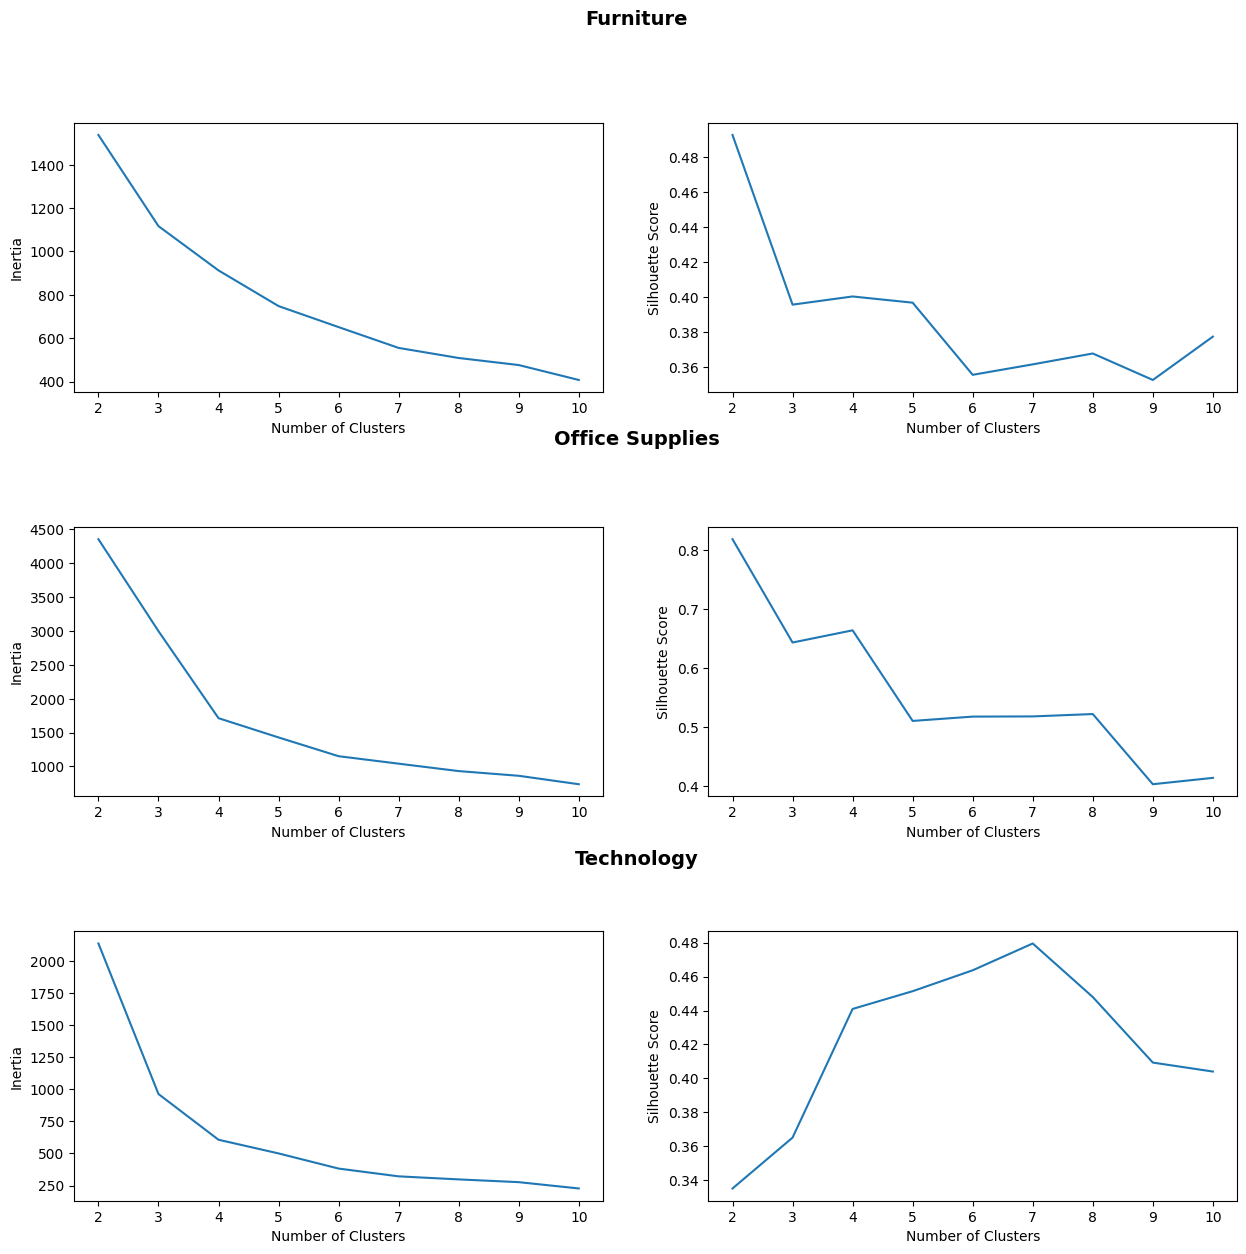

In [19]:
find_optimal_k(dataframes_scaled)

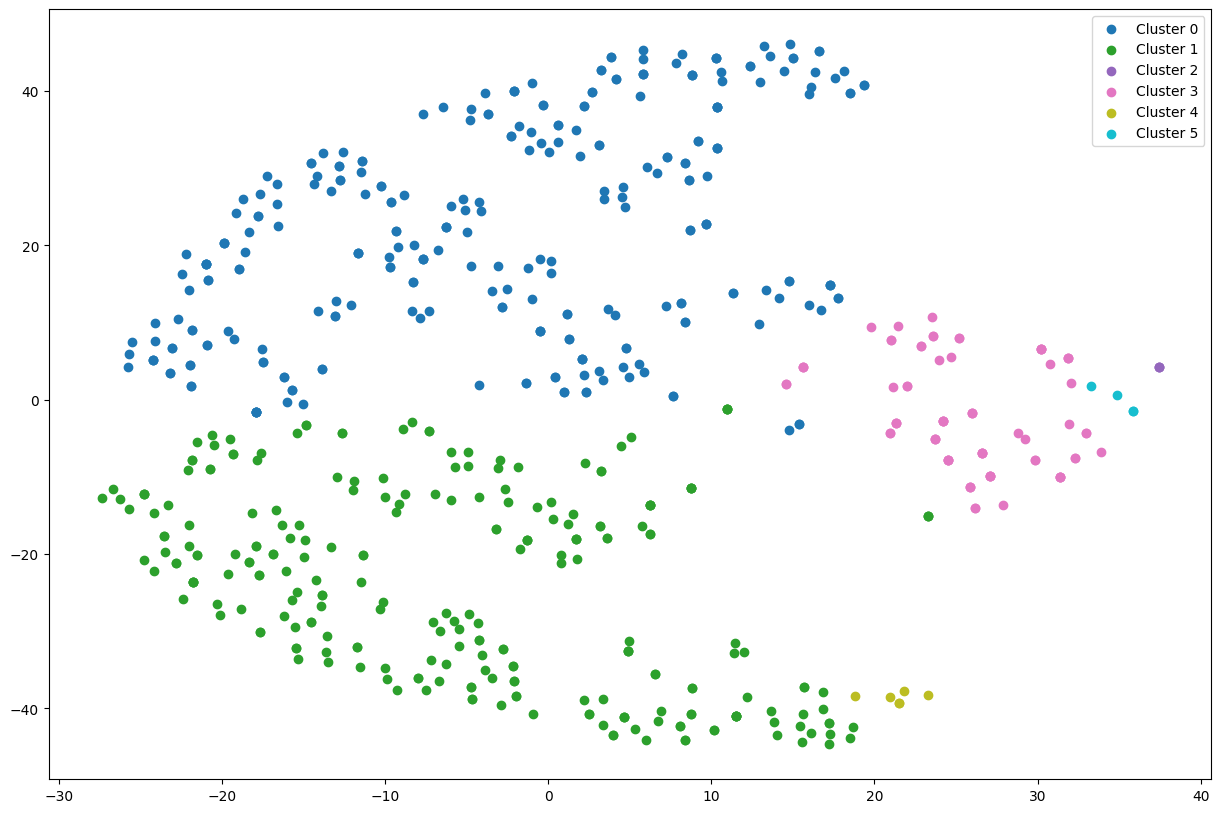

In [20]:
training_data = dataframes_scaled["Technology"].copy()
model = KMeans(n_clusters = 6, init = "k-means++", random_state = 42)
model.fit(training_data)

visualize_clusters(model, training_data)

In [21]:
def cluster_product_data(dataframes_scaled : dict, num_clusters : dict): 
    for category in dataframes_scaled.keys(): 
        model = KMeans(n_clusters = num_clusters[category], init = "k-means++", random_state=42)
        dataframes_scaled[category]["Cluster"] = model.fit_predict(dataframes_scaled[category])


In [22]:
num_clusters = {"Technology" : 6, "Office Supplies" : 5, "Furniture" : 4}
cluster_product_data(dataframes_scaled, num_clusters)

In [23]:
dataframes_scaled["Technology"]["Margin"] = data["Technology"]["Margin"]
get_coefficient_variation(dataframes_scaled["Technology"], "Cluster")

,Cluster,Mean,Std,CoefficientOfVariation
2,2,0.436667,0.075056,0.029544
0,0,0.297903,0.103529,0.120773
4,4,-0.783194,0.590353,0.568178
3,3,0.175238,0.183231,1.093309
5,5,-0.379028,0.704400,3.453794
1,1,0.032910,0.149236,20.563587


In [36]:
dataframes_scaled["Technology"]["SubCategory"] = data["Technology"]["SubCategory"]
dataframes_scaled["Technology"][dataframes_scaled["Technology"]["Cluster"] == 3]["SubCategory"].value_counts()

SubCategory
Phones         44
Accessories    17
Copiers        10
Machines        6
Name: count, dtype: int64

In [24]:
get_coefficient_variation(grouped_dataframes["Technology"], "Segment")

,Segment,Mean,Std,CoefficientOfVariation
0,Consumer,0.161175,0.206200,1.636751
1,Corporate,0.159820,0.229931,2.069822
2,Home Office,0.167267,0.241871,2.090972


### Customer Clustering

Compute revenue for costumer within each cluster. 

In [25]:


merged = {}
for category in dataframes_scaled.keys():
    dataframes_scaled[category]["RowID"] = data[category]["RowID"]
    merged[category] = pd.merge(dataframes_scaled[category], grouped_dataframes[category], on = "RowID")

merged["Technology"].head()

,TotalSales,TotalCost,MeanMargin,AverageSalesPastMonths,Cluster,Margin_x,RowID,OrderDate,OrderID,ShipMode,...,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Discount,Profit,Cost,Margin_y
0,1.446462,1.478574,0.511776,4.658876,3,0.2600,6341,2020-10-05,CA-2017-143112,Standard Class,...,TEC-MA-10001047,Technology,Machines,3D Systems Cube Printer 2nd Generation Magenta,5199.960,4,0.0,1351.9896,961.9926,0.2600
1,-0.032251,1.425097,-0.324694,0.591125,3,0.1000,6364,2020-11-21,CA-2017-110443,Standard Class,...,TEC-MA-10002073,Technology,Machines,3D Systems Cube Printer 2nd Generation White,1039.992,1,0.2,103.9992,935.9928,0.1000
2,-0.377829,-0.465879,-0.742929,-0.359516,1,0.0200,9861,2020-01-14,CA-2017-113278,Standard Class,...,TEC-PH-10000169,Technology,Phones,ARKON Windshield Dashboard Air Vent Car Mount ...,67.800,4,0.0,1.3560,16.6110,0.0200
3,-0.216889,0.117010,-0.602065,-0.256139,1,0.0875,9444,2020-04-07,CA-2017-165904,Standard Class,...,TEC-PH-10000576,Technology,Phones,AT&T 1080 Corded phone,219.184,2,0.2,19.1786,100.0027,0.0875
4,-0.216889,0.117010,-0.602065,-0.256139,1,0.2700,2465,2020-12-03,CA-2017-148691,Standard Class,...,TEC-PH-10000576,Technology,Phones,AT&T 1080 Corded phone,136.990,1,0.0,36.9873,100.0027,0.2700


In [26]:
def merge_customer_clustering_data(product_dataframes, original_dataframes):
    for category in product_dataframes.keys(): 
        data = 

SyntaxError: invalid syntax (1725188794.py, line 3)

In [ ]:
def calculate_customer_revenue_in_cluster(customerID, category, cluster): 
    